<a href="https://colab.research.google.com/github/EslamKampoza/machine-intelligence-paper-/blob/main/oppo_SMOTE_orig12-1-2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from imblearn.metrics import classification_report_imbalanced

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class models():
    def __init__(self, path):
        self.path = path
       
    
    def read_h5(self):
        f = h5py.File(path, 'r')
        X = f.get('inputs')
        y = f.get('labels') 
        #print(type(X))
        #print(type(y))
        self.X = np.array(X)
        self.y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.4, random_state = 1)
    
        print("X = ", self.X.shape)
        print("y =",self.y.shape)
        print(set(self.y))
        #return X,y
    
    def cnn_model(self):
       # K = len(set(y_train))
        #print(K)
        K = len(set(self.y))
        #X = np.expand_dims(X, -1)
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test,-1)
        #print(X)
        #print(X[0].shape)
        #i = Input(shape=X[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Conv2D(32, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(i)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.2)(x)
        x = Conv2D(64, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(128, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)    
        x = Dropout(0.2)(x)
        x = Dense(1024,activation = 'relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(K, activation = 'softmax')(x)       
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

        #self.r = model.fit(X, y, validation_split = 0.4, epochs = 50, batch_size = 32 )
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50, batch_size = 32 )
        print(self.model.summary())
        # It is better than using keras do the splitting!!
        return self.r
    
    def dnn_model(self):
       # K = len(set(y_train))
        #print(K)
        K = len(set(self.y))
        print(self.x_train[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Flatten()(i)
        x = Dense(128,activation = 'relu')(x)
        x = Dense(128,activation = 'relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(256,activation = 'relu')(x)
        x = Dense(256,activation = 'relu')(x)
        x = Dense(256,activation = 'relu')(x)
        #x = Dropout(0.2)(x)
        x = Dense(1024,activation = 'relu')(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)      
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        
        '''
        K = len(set(self.y))
        model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=self.x_train[0].shape),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(K,activation = 'softmax')
        ])
        model.compile(optimizer = Adam(lr=0.0005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        '''
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50 )
        print(self.model.summary())
        return self.r
    

    def rnn_model(self):
        K = len(set(self.y))
        i = Input(shape = self.x_train[0].shape)
        x = LSTM(256, return_sequences=True)(i)
        x = Dense(128,activation = 'relu')(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)      
        self.model.compile(optimizer = Adam(lr=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50, batch_size = 32 )
        #self.r = model.fit(X, y, validation_split = 0.2, epochs = 10, batch_size = 32 )
        print(self.model.summary())
        return self.r
   
    def draw(self):
        f1 = plt.figure(1)
        plt.title('Loss')
        plt.plot(self.r.history['loss'], label = 'loss')
        plt.plot(self.r.history['val_loss'], label = 'val_loss')
        plt.legend()
        f1.show()
        
        f2 = plt.figure(2)
        plt.plot(self.r.history['acc'], label = 'accuracy')
        plt.plot(self.r.history['val_acc'], label = 'val_accuracy')
        plt.legend()
        f2.show()
        
    # summary, confusion matrix and heatmap
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict(self.x_test).argmax(axis=1)
        cm = confusion_matrix(self.y_test,self.y_pred)
        self.plot_confusion_matrix(cm,list(range(K)))
            
    
    def plot_confusion_matrix(self, cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
        print(cm)
        f3 = plt.figure(3)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('predicted label')
            f3.show()



In [5]:
model_name = "rnn" # can be cnn/dnn/rnn
loco = True # True is to use locomotion as labels. False is to use high level activities as labels
#path = "loco_2.h5"
path = ""
if loco:
    path = "./drive/MyDrive/datasets/loco_2.h5"
else:
    path = "./drive/MyDrive/datasets/hl_2.h5"
        
oppo = models(path)
    
print("read h5 file....")
oppo.read_h5()   
#if model_name == "cnn":
#    oppo.cnn_model()
#elif model_name == "dnn":
#     oppo.dnn_model()
#elif model_name == "rnn":
#     oppo.rnn_model()
#oppo.draw()
#oppo.con_matrix()

read h5 file....
X =  (31042, 25, 220)
y = (31042,)
{0, 1, 2, 3}


In [6]:
unique,counts = np.unique(oppo.y,return_counts = True)
dict(zip(unique,counts))

{0: 1665, 1: 13968, 2: 7427, 3: 7982}

In [7]:
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [8]:
##Ploting Confusion Matrix
def plot_confusion_matrix (cm, classes, normalize=False, title='Confusion Matrix', cmap=pyplot.cm.Blues,
                           decsnTreeClf=None):
    #This function prints and plots the confusion matrix.
    pyplot.imshow(cm,interpolation='nearest',cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks=np.arange(len(classes))
    pyplot.xticks(tick_marks,classes,rotation=45)
    pyplot.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j,i,cm[i,j],horizontalalignment="center", color="white" if cm[i,j]> thresh else "black" )

    pyplot.tight_layout()
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')
    pyplot.show()

In [9]:
xshape = oppo.x_train.shape
newx_train = oppo.x_train.reshape(xshape[0],(xshape[1]*xshape[2]))

In [10]:
xshape = oppo.x_test.shape
newx_test = oppo.x_test.reshape(xshape[0],(xshape[1]*xshape[2]))

In [11]:
sm = SMOTE(random_state = 2)
Data_res,labels_res = sm.fit_resample(newx_train,oppo.y_train)

In [12]:
unique,counts = np.unique(oppo.y_train,return_counts = True)
dict(zip(unique,counts))

{0: 1041, 1: 8356, 2: 4445, 3: 4783}

In [13]:
unique,counts = np.unique(labels_res,return_counts = True)
dict(zip(unique,counts))

{0: 8356, 1: 8356, 2: 8356, 3: 8356}

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler , MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(Data_res)
#trainData = scaler.transform(Data_res)
#testData = scaler.transform(newx_test)

In [15]:
#encoding Labels

encoder = LabelEncoder()

#encoding test labels

encoder.fit(oppo.y_test)
testLabelE = encoder.transform(oppo.y_test)

#encoding train labels

encoder.fit(labels_res)
trainLabelE = encoder.transform(labels_res)

K-Nearest Neighbors Accuracy: 0.89257
Confusion matrix, without normalization
[[ 623    0    0    1]
 [   1 5363  152   96]
 [   0  989 1949   44]
 [  31   14    6 3148]]


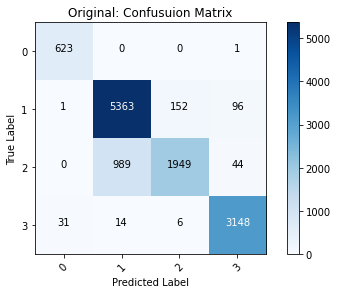

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       624
           1       0.84      0.96      0.90      5612
           2       0.93      0.65      0.77      2982
           3       0.96      0.98      0.97      3199

    accuracy                           0.89     12417
   macro avg       0.92      0.90      0.90     12417
weighted avg       0.90      0.89      0.89     12417

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      1.00      0.97      1.00      1.00       624
          1       0.84      0.96      0.85      0.90      0.90      0.82      5612
          2       0.93      0.65      0.98      0.77      0.80      0.62      2982
          3       0.96      0.98      0.98      0.97      0.98      0.97      3199

avg / total       0.90      0.89      0.93      0.89      0.90      0.82     12417



In [16]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
clf2= KNeighborsClassifier(n_neighbors=12)
knnModel2 = clf2.fit(Data_res,labels_res)
y_te_pred2 = clf2.predict(newx_test)

acc2 = accuracy_score(testLabelE,y_te_pred2)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(oppo.y_test,y_te_pred2)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(oppo.y_test,y_te_pred2))
print(classification_report_imbalanced(testLabelE,y_te_pred2))

K-Nearest Neighbors Accuracy: 0.91149
Confusion matrix, without normalization
[[ 622    0    0    2]
 [   1 5439  127   45]
 [   0  852 2100   30]
 [  25   12    5 3157]]


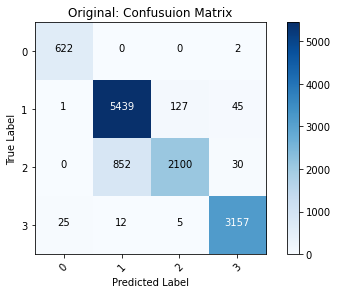

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       624
           1       0.86      0.97      0.91      5612
           2       0.94      0.70      0.81      2982
           3       0.98      0.99      0.98      3199

    accuracy                           0.91     12417
   macro avg       0.93      0.91      0.92     12417
weighted avg       0.92      0.91      0.91     12417

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      1.00      0.98      1.00      0.99       624
          1       0.86      0.97      0.87      0.91      0.92      0.85      5612
          2       0.94      0.70      0.99      0.81      0.83      0.67      2982
          3       0.98      0.99      0.99      0.98      0.99      0.98      3199

avg / total       0.92      0.91      0.94      0.91      0.92      0.85     12417



In [17]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
clf2= KNeighborsClassifier(n_neighbors=4)
knnModel2 = clf2.fit(Data_res,labels_res)
y_te_pred2 = clf2.predict(newx_test)

acc2 = accuracy_score(testLabelE,y_te_pred2)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(testLabelE,y_te_pred2)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(testLabelE,y_te_pred2))
print(classification_report_imbalanced(testLabelE,y_te_pred2))

In [ ]:
from sklearn import svm

model = svm.SVC(kernel='rbf') 
model.fit(Data_res,labels_res)
y_pred= model.predict(newx_test)

acc2 = accuracy_score(testLabelE,y_pred)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(testLabelE,y_pred)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(testLabelE,y_pred))
print(classification_report_imbalanced(testLabelE,y_pred))

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier() 
model.fit(Data_res,labels_res)
y_pred= model.predict(newx_test)

acc2 = accuracy_score(testLabelE,y_pred)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(testLabelE,y_pred)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(testLabelE,y_pred))
print(classification_report_imbalanced(testLabelE,y_pred))